In [1]:
import os
import json
import numpy as np
import xarray as xr
import geopandas as gpd

import cartopy.crs as ccrs

from multiprocessing import Pool

from playsound import playsound

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import sys
sys.path.append(os.path.abspath(".."))
from function import ART_downscale as ART_down

playsound is relying on another python subprocess. Please use `pip install pygobject` if you want playsound to run more efficiently.


In [46]:
# product, time_reso = 'CMORPH', '3h'
# product, time_reso = 'ERA5', '1dy'
# product, time_reso = 'ERA5', '3h'
# product, time_reso = 'IMERG', '1dy'
# product, time_reso = 'IMERG', '3h'
# product, time_reso = 'PERSIANN', '1dy'
# product, time_reso = 'MSWEP', '3h'
# product, time_reso = 'SM2RAIN', '1dy'
# product, time_reso = 'GSMaP', '3h'
product, time_reso = 'CHIRPS', '1dy'

if product == 'SM2RAIN':
    yy_s, yy_e = 2007, 2012
    # yy_s, yy_e = 2007, 2022
    year_vector = np.arange(yy_s, yy_e+1)
else:
    yy_s, yy_e = 2002, 2012
    # yy_s, yy_e = 2002, 2023
    year_vector = np.arange(yy_s, yy_e+1)

years_num = yy_e - yy_s + 1
lon_min, lon_max, lat_min, lat_max = 10.5, 13.5, 44.5, 47

In [47]:
dir_base = os.path.join('/','media','arturo','Arturo','Data','Italy','Satellite')

In [48]:
json_read = f'../json/{product}_{time_reso}.json'

if os.path.exists(json_read):
    with open (json_read) as f:
        param = json.load(f)
else:
    raise SystemExit(f"File not found: {json_read}")

NEIBHR = 2*param['npix']+1

print(f'Read json file   : {json_read.split('/')[-1]}')
print(f'Number of threads: {param['BETA_cores']}')
print(f'Neighborhood area: {NEIBHR}x{NEIBHR}')
print()

Read json file   : CHIRPS_1dy.json
Number of threads: 20
Neighborhood area: 5x5



In [49]:
veneto_dir = os.path.join('/','media','arturo','Arturo','Data','shapes','Europa','Italy')

if os.path.exists(veneto_dir):
    VENETO = gpd.read_file(os.path.join(veneto_dir,'Veneto.geojson'))
else:
    raise SystemExit(f"File not found: {veneto_dir}")

In [51]:
print(f'Reading Data File : {param['file']}') 
if product == 'SM2RAIN':
    dir_data = os.path.join(dir_base,product,'ASCAT',time_reso,param['file'])
else:
    dir_data = os.path.join(dir_base,product,time_reso,param['file'])

PRE_data = xr.open_dataset(dir_data)
PRE_data = PRE_data.sel(time=PRE_data.time.dt.year.isin([np.arange(yy_s,yy_e+1)]))

if product == 'MSWEP' or product == 'PERSIANN' or product == 'SM2RAIN' or product == 'ERA5' or product == 'GSMaP':
    PRE_data = PRE_data.sel(lat=slice(lat_max, lat_min), lon=slice(lon_min, lon_max))
else:
    PRE_data = PRE_data.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))

if time_reso == '3h':
    PRE_data = PRE_data.resample(time ='D').sum(dim='time', skipna=False)

time_vector = PRE_data['time'].data

lats = PRE_data['lat'].data
lons = PRE_data['lon'].data
lon2d, lat2d = np.meshgrid(lons, lats)

ntime, nlat, nlon = PRE_data['PRE'].shape

PRE_data

Reading Data File : CHIRPS_Italy_1dy_1981_01_01_2024_06_30.nc


<xarray.Dataset> Size: 48MB
Dimensions:  (time: 4018, lat: 50, lon: 60)
Coordinates:
  * time     (time) datetime64[ns] 32kB 2002-01-01 2002-01-02 ... 2012-12-31
  * lat      (lat) float32 200B 44.52 44.57 44.62 44.67 ... 46.87 46.92 46.97
  * lon      (lon) float32 240B 10.52 10.57 10.62 10.68 ... 13.38 13.43 13.47
Data variables:
    PRE      (time, lat, lon) float32 48MB ...
Attributes:
    description:  CHIRPS daily data for Italy region

## Comparison between functions

In [55]:
N = np.zeros((years_num, nlat, nlon))*np.nan
C = np.zeros((years_num, nlat, nlon))*np.nan
W = np.zeros((years_num, nlat, nlon))*np.nan

N1 = np.zeros((years_num, nlat, nlon))*np.nan
C1 = np.zeros((years_num, nlat, nlon))*np.nan
W1 = np.zeros((years_num, nlat, nlon))*np.nan

N2 = np.zeros((years_num, nlat, nlon))*np.nan
C2 = np.zeros((years_num, nlat, nlon))*np.nan
W2 = np.zeros((years_num, nlat, nlon))*np.nan

for yy in range(years_num):
    PRE_year = PRE_data.sel(time=PRE_data.time.dt.year.isin([yy_s+yy]))
    for i in range(nlat):
        for j in range(nlon):
            PRE = PRE_year['PRE'].values[:,i,j]
            excesses = PRE[PRE > 1]
            if excesses.size == 0:
                continue
            else:
                n, c, w = ART_down.wei_fit_update(excesses)
                N[yy,i,j] = n
                C[yy,i,j] = c
                W[yy,i,j] = w

                n1, c1, w1 = ART_down.wei_fit_pwm(excesses)
                N1[yy,i,j] = n1
                C1[yy,i,j] = c1
                W1[yy,i,j] = w1

                n2, c2, w2 = ART_down.wei_fit_pwm_cens(excesses)
                N2[yy,i,j] = n2
                C2[yy,i,j] = c2
                W2[yy,i,j] = w2

/tmp/ipykernel_10299/900931637.py:12: RuntimeWarning: Mean of empty slice
  a1 = ax1.pcolormesh(lon2d, lat2d, np.nanmean(C,axis=0),cmap=cmap)
/tmp/ipykernel_10299/900931637.py:33: RuntimeWarning: Mean of empty slice
  a1 = ax1.pcolormesh(lon2d, lat2d, np.nanmean(C1,axis=0),cmap=cmap)
/tmp/ipykernel_10299/900931637.py:54: RuntimeWarning: Mean of empty slice
  a1 = ax1.pcolormesh(lon2d, lat2d, np.nanmean(C2,axis=0),cmap=cmap)


Text(0.0, 1.0, '(c) Scale')

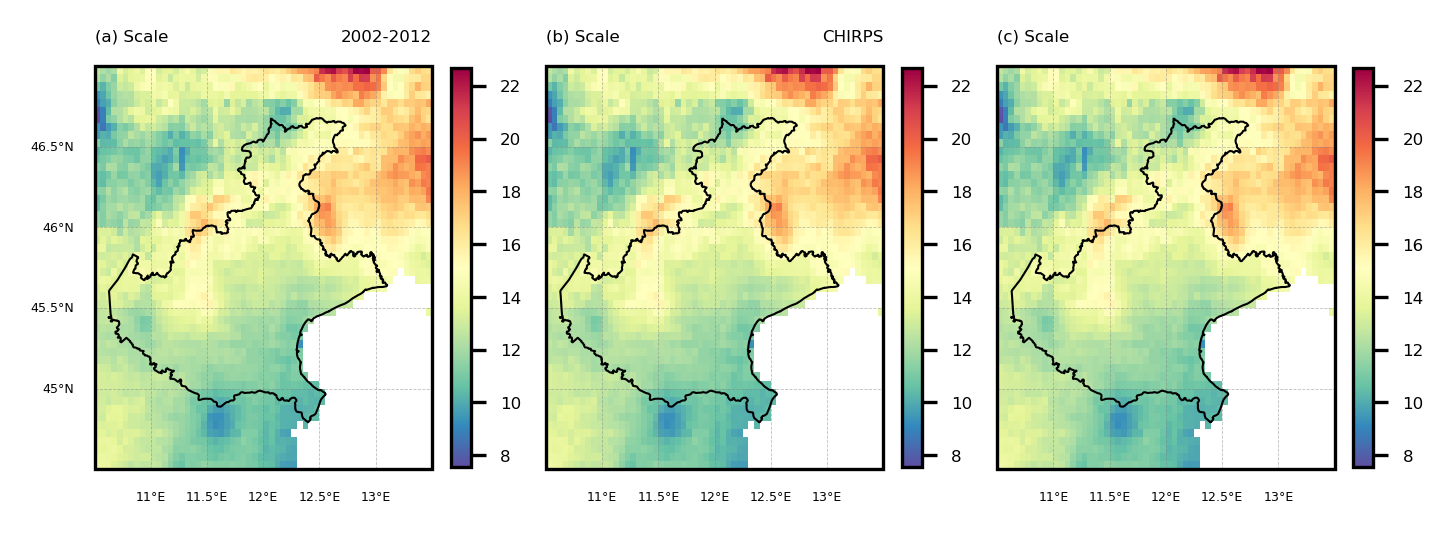

In [56]:
cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(5.5,2),dpi=300)
gs = gridspec.GridSpec(1,3)

# ==============================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max],crs=proj)
VENETO.plot(facecolor='None', ax=ax1, linewidth=0.5, zorder=10)

a1 = ax1.pcolormesh(lon2d, lat2d, np.nanmean(C,axis=0),cmap=cmap)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = True
gl.xlabel_style = {'size': 3, 'color': 'k'}
gl.ylabel_style = {'size': 3, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.053)
cbar.ax.tick_params(labelsize=4)

ax1.set_title(f'(a) Scale', fontsize=4, loc='left')
ax1.set_title(f'{yy_s}-{yy_e}', fontsize=4, loc='right')

# ==============================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max],crs=proj)
VENETO.plot(facecolor='None', ax=ax1, linewidth=0.5, zorder=10)

a1 = ax1.pcolormesh(lon2d, lat2d, np.nanmean(C1,axis=0),cmap=cmap)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 3, 'color': 'k'}
gl.ylabel_style = {'size': 3, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.053)
cbar.ax.tick_params(labelsize=4)

ax1.set_title(f'(b) Scale', fontsize=4, loc='left')
ax1.set_title(product, fontsize=4, loc='right')

# ==============================================================================
ax1 = plt.subplot(gs[0, 2], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max],crs=proj)
VENETO.plot(facecolor='None', ax=ax1, linewidth=0.5, zorder=10)

a1 = ax1.pcolormesh(lon2d, lat2d, np.nanmean(C2,axis=0),cmap=cmap)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 3, 'color': 'k'}
gl.ylabel_style = {'size': 3, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.053)
cbar.ax.tick_params(labelsize=4)

ax1.set_title(f'(c) Scale', fontsize=4, loc='left')

/tmp/ipykernel_10299/3733569472.py:12: RuntimeWarning: Mean of empty slice
  a1 = ax1.pcolormesh(lon2d, lat2d, np.nanmean(W,axis=0),cmap=cmap)
/tmp/ipykernel_10299/3733569472.py:33: RuntimeWarning: Mean of empty slice
  a1 = ax1.pcolormesh(lon2d, lat2d, np.nanmean(W1,axis=0),cmap=cmap)
/tmp/ipykernel_10299/3733569472.py:54: RuntimeWarning: Mean of empty slice
  a1 = ax1.pcolormesh(lon2d, lat2d, np.nanmean(W2,axis=0),cmap=cmap)


Text(0.0, 1.0, '(c) Scale')

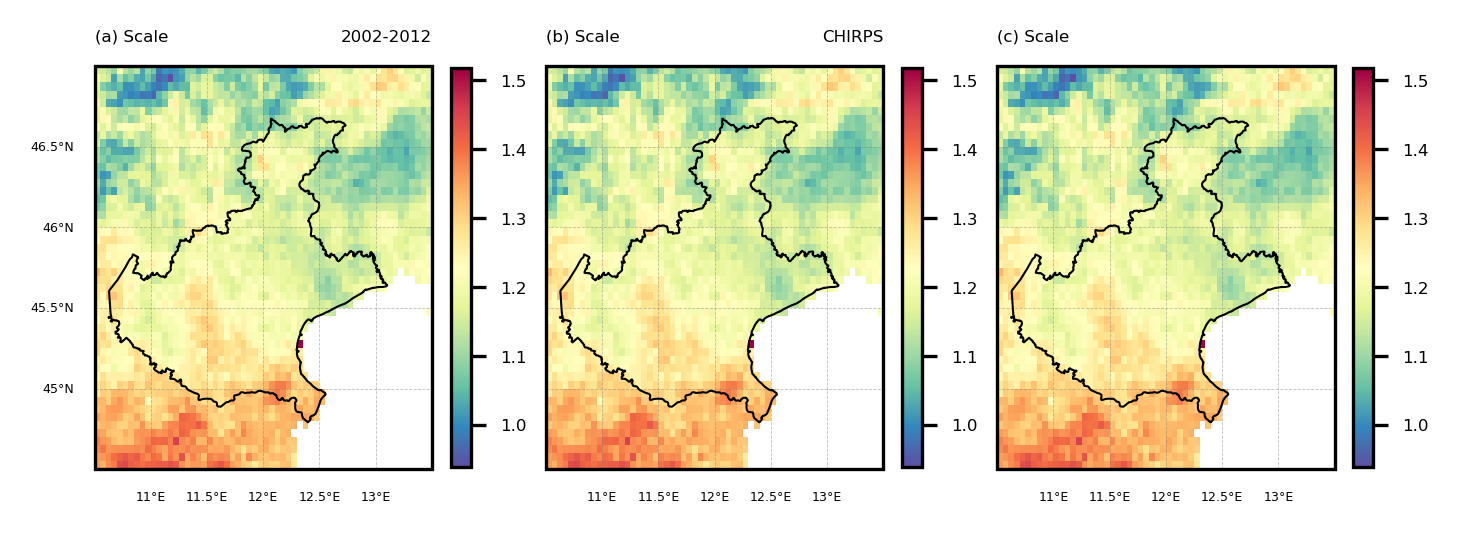

In [57]:
cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(5.5,2),dpi=300)
gs = gridspec.GridSpec(1,3)

# ==============================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max],crs=proj)
VENETO.plot(facecolor='None', ax=ax1, linewidth=0.5, zorder=10)

a1 = ax1.pcolormesh(lon2d, lat2d, np.nanmean(W,axis=0),cmap=cmap)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = True
gl.xlabel_style = {'size': 3, 'color': 'k'}
gl.ylabel_style = {'size': 3, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.053)
cbar.ax.tick_params(labelsize=4)

ax1.set_title(f'(a) Scale', fontsize=4, loc='left')
ax1.set_title(f'{yy_s}-{yy_e}', fontsize=4, loc='right')

# ==============================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max],crs=proj)
VENETO.plot(facecolor='None', ax=ax1, linewidth=0.5, zorder=10)

a1 = ax1.pcolormesh(lon2d, lat2d, np.nanmean(W1,axis=0),cmap=cmap)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 3, 'color': 'k'}
gl.ylabel_style = {'size': 3, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.053)
cbar.ax.tick_params(labelsize=4)

ax1.set_title(f'(b) Scale', fontsize=4, loc='left')
ax1.set_title(product, fontsize=4, loc='right')

# ==============================================================================
ax1 = plt.subplot(gs[0, 2], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max],crs=proj)
VENETO.plot(facecolor='None', ax=ax1, linewidth=0.5, zorder=10)

a1 = ax1.pcolormesh(lon2d, lat2d, np.nanmean(W2,axis=0),cmap=cmap)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 3, 'color': 'k'}
gl.ylabel_style = {'size': 3, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.053)
cbar.ax.tick_params(labelsize=4)

ax1.set_title(f'(c) Scale', fontsize=4, loc='left')

## Comparison for threshold
### excesses = PRE[PRE > 1] 
### excesses = PRE[PRE > 1] - 1

In [58]:
N1 = np.zeros((years_num, nlat, nlon))*np.nan
C1 = np.zeros((years_num, nlat, nlon))*np.nan
W1 = np.zeros((years_num, nlat, nlon))*np.nan

for yy in range(years_num):
    PRE_year = PRE_data.sel(time=PRE_data.time.dt.year.isin([yy_s+yy]))
    for i in range(nlat):
        for j in range(nlon):
            PRE = PRE_year['PRE'].values[:,i,j]
            excesses = PRE[PRE > 1]
            if excesses.size == 0:
                continue
            else:
                n1, c1, w1 = ART_down.wei_fit_pwm(excesses)
                N1[yy,i,j] = n1
                C1[yy,i,j] = c1
                W1[yy,i,j] = w1

In [59]:
N2 = np.zeros((years_num, nlat, nlon))*np.nan
C2 = np.zeros((years_num, nlat, nlon))*np.nan
W2 = np.zeros((years_num, nlat, nlon))*np.nan

for yy in range(years_num):
    PRE_year = PRE_data.sel(time=PRE_data.time.dt.year.isin([yy_s+yy]))
    for i in range(nlat):
        for j in range(nlon):
            PRE = PRE_year['PRE'].values[:,i,j]
            excesses = PRE[PRE > 1] - 1
            if excesses.size == 0:
                continue
            else:
                n2, c2, w2 = ART_down.wei_fit_pwm(excesses)
                N2[yy,i,j] = n2
                C2[yy,i,j] = c2
                W2[yy,i,j] = w2

/tmp/ipykernel_10299/491597198.py:12: RuntimeWarning: Mean of empty slice
  a1 = ax1.pcolormesh(lon2d, lat2d, np.nanmean(W,axis=0),cmap=cmap)
/tmp/ipykernel_10299/491597198.py:33: RuntimeWarning: Mean of empty slice
  a1 = ax1.pcolormesh(lon2d, lat2d, np.nanmean(W1,axis=0),cmap=cmap)
/tmp/ipykernel_10299/491597198.py:54: RuntimeWarning: Mean of empty slice
  a1 = ax1.pcolormesh(lon2d, lat2d, np.nanmean(W,axis=0)-np.nanmean(W1,axis=0),cmap=cmap)


Text(0.0, 1.0, '(c) Scale')

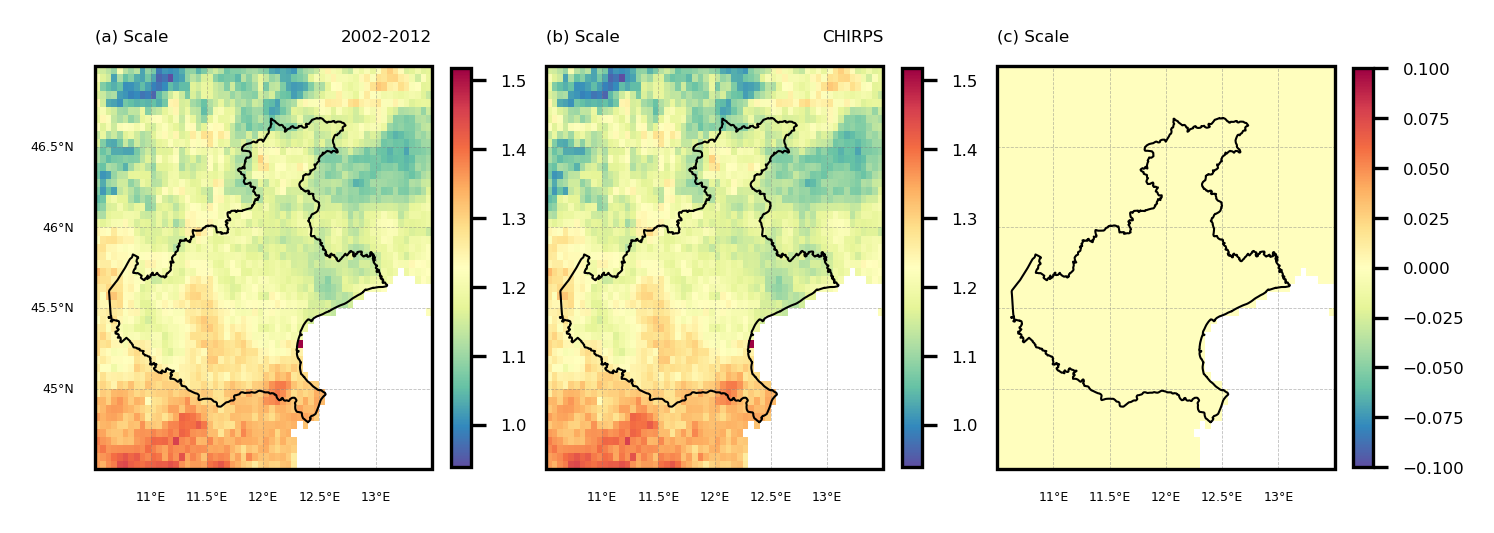

In [63]:
cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(5.5,2),dpi=300)
gs = gridspec.GridSpec(1,3)

# ==============================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max],crs=proj)
VENETO.plot(facecolor='None', ax=ax1, linewidth=0.5, zorder=10)

a1 = ax1.pcolormesh(lon2d, lat2d, np.nanmean(W,axis=0),cmap=cmap)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = True
gl.xlabel_style = {'size': 3, 'color': 'k'}
gl.ylabel_style = {'size': 3, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.053)
cbar.ax.tick_params(labelsize=4)

ax1.set_title(f'(a) Scale', fontsize=4, loc='left')
ax1.set_title(f'{yy_s}-{yy_e}', fontsize=4, loc='right')

# ==============================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max],crs=proj)
VENETO.plot(facecolor='None', ax=ax1, linewidth=0.5, zorder=10)

a1 = ax1.pcolormesh(lon2d, lat2d, np.nanmean(W1,axis=0),cmap=cmap)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 3, 'color': 'k'}
gl.ylabel_style = {'size': 3, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.053)
cbar.ax.tick_params(labelsize=4)

ax1.set_title(f'(b) Scale', fontsize=4, loc='left')
ax1.set_title(product, fontsize=4, loc='right')

# ==============================================================================
ax1 = plt.subplot(gs[0, 2], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max],crs=proj)
VENETO.plot(facecolor='None', ax=ax1, linewidth=0.5, zorder=10)

a1 = ax1.pcolormesh(lon2d, lat2d, np.nanmean(W,axis=0)-np.nanmean(W1,axis=0),cmap=cmap)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 3, 'color': 'k'}
gl.ylabel_style = {'size': 3, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.053)
cbar.ax.tick_params(labelsize=4)

ax1.set_title(f'(c) Scale', fontsize=4, loc='left')